In [3]:
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from arch import arch_model

In [21]:
data = pd.read_excel('C:/Users/michelj8/Documents/Github/data_sets/sp500_fred.xlsx', sheet_name = 'data')
data = data.query('observation_date < 2020 & observation_date > 1959')
# data = data.dropna().reset_index()
column_name = data.columns[-1]
data.head()

,observation_date,SP500
0,2015-10-01,1923.82
1,2015-10-02,1951.36
2,2015-10-05,1987.05
3,2015-10-06,1979.92
4,2015-10-07,1995.83


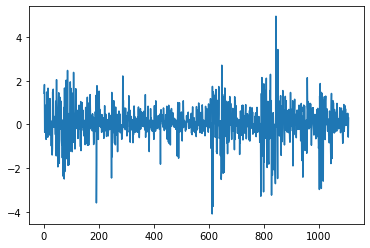

In [32]:
ts = data
ts['target'] = 100* ts[column_name].pct_change(1)
ts['target'].plot()
ts = ts.dropna()

# GARCH(1,1)

In [45]:
garch_fit = arch_model(ts['target']).fit(disp = 'off')
ts['garch'] = garch_fit.conditional_volatility
print(garch_fit)

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 target   R-squared:                      -0.003
Mean Model:             Constant Mean   Adj. R-squared:                 -0.003
Vol Model:                      GARCH   Log-Likelihood:               -1139.46
Distribution:                  Normal   AIC:                           2286.91
Method:            Maximum Likelihood   BIC:                           2306.81
                                        No. Observations:                 1069
Date:                Tue, Oct 20 2020   Df Residuals:                     1065
Time:                        09:07:56   Df Model:                            4
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0931  1.901e-02      4.898  9.680e-07 [5.586e-0

<ipython-input-45-a7ae82b5de36>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['garch'] = garch_fit.conditional_volatility


# GJR

In [46]:
gjr_fit = arch_model(ts['target'], p=1, o=1, q=1).fit(disp = 'off')
ts['gjr'] = gjr_fit.conditional_volatility
print(gjr_fit)

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                 target   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -1118.52
Distribution:                  Normal   AIC:                           2247.05
Method:            Maximum Likelihood   BIC:                           2271.92
                                        No. Observations:                 1069
Date:                Tue, Oct 20 2020   Df Residuals:                     1064
Time:                        09:08:13   Df Model:                            5
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0563  1.752e-02      3.212  1.318e-03 [2.

<ipython-input-46-f6251a7b5b4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['gjr'] = gjr_fit.conditional_volatility


# GARCH(1,1) with student t

In [56]:
t_garch_fit = arch_model(ts['target'], dist='StudentsT').fit(update_freq=5)
ts['t_garch'] = t_garch_fit.conditional_volatility
print(t_garch_fit)

Iteration:      5,   Func. Count:     39,   Neg. LLF: 2129.261721506104
Iteration:     10,   Func. Count:     74,   Neg. LLF: 1086.8098849198468
Iteration:     15,   Func. Count:    106,   Neg. LLF: 1086.4625501559326
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1086.4625492192313
            Iterations: 16
            Function evaluations: 112
            Gradient evaluations: 16
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                       target   R-squared:                      -0.001
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                            GARCH   Log-Likelihood:               -1086.46
Distribution:      Standardized Student's t   AIC:                           2182.93
Method:                  Maximum Likelihood   BIC:                           2207.80
                                              No. Observation

<ipython-input-56-8b989174ec1d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['t_garch'] = t_garch_fit.conditional_volatility


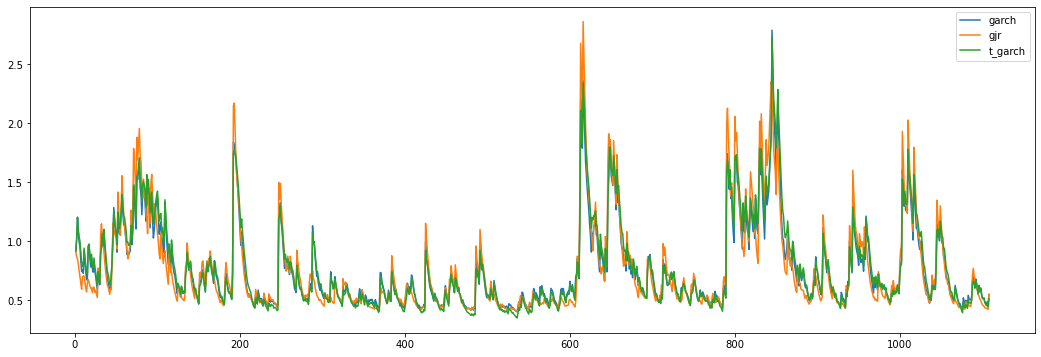

In [57]:
fig, ax = plt.subplots(figsize = (18,6))
ts[['garch','gjr','t_garch']].plot(ax = ax)

In [98]:
ts.head()

,observation_date,SP500,target,garch,gjr,t_garch
1,2015-10-02,1951.36,1.431527,0.911623,0.909763,0.919058
2,2015-10-05,1987.05,1.828981,1.017579,0.862505,1.021339
3,2015-10-06,1979.92,-0.358823,1.203658,0.853009,1.198909
4,2015-10-07,1995.83,0.803568,1.070285,0.806523,1.096168
5,2015-10-08,2013.43,0.881839,0.994086,0.746110,1.037820


# Analysis of models

# PITS

In [109]:
garch_pits = []
gjr_pits = []
t_garch_pits = []

garch_mean = garch_fit.params[0]    
gjr_mean = gjr_fit.params[0]
t_garch_mean = t_garch_fit.params[0]    
t_garch_dist = t_garch_fit.params[4]


for time in ts.index:
    actual = ts.loc[time,'target']
    
    garch_vol =  ts.loc[time,'garch']
    gjr_vol = ts.loc[time,'gjr']
    t_garch_vol = ts.loc[time,'t_garch']

    garch_pits.append( scipy.stats.norm.cdf(actual, loc=garch_mean, scale=garch_vol))
    gjr_pits.append(scipy.stats.norm.cdf(actual, loc=gjr_mean, scale=gjr_vol))
    t_garch_pits.append( scipy.stats.t.cdf(actual, t_garch_dist, loc=t_garch_mean, scale=t_garch_vol) )

    
print(stats.kstest(garch_pits, 'uniform'))
print(stats.kstest(gjr_pits, 'uniform'))
print(stats.kstest(t_garch_pits, 'uniform'))

KstestResult(statistic=0.0647527797970473, pvalue=0.00024334117096144604)
KstestResult(statistic=0.05970435410725611, pvalue=0.0009375002481499268)
KstestResult(statistic=0.0656494799070394, pvalue=0.00018932071855088287)


# KL Divergence

In [104]:
garch_kl = 0
gjr_kl = 0
t_garch_kl = 0

garch_mean = garch_fit.params[0]    
gjr_mean = gjr_fit.params[0]
t_garch_mean = t_garch_fit.params[0]    
t_garch_dist = t_garch_fit.params[4]


for time in ts.index:
    actual = ts.loc[time,'target']
    
    garch_vol =  ts.loc[time,'garch']
    gjr_vol = ts.loc[time,'gjr']
    t_garch_vol = ts.loc[time,'t_garch']

    garch_kl = garch_kl + scipy.stats.norm.logpdf(actual, loc=garch_mean, scale=garch_vol)
    gjr_kl = gjr_kl + scipy.stats.norm.logpdf(actual, loc=gjr_mean, scale=gjr_vol)
    t_garch_kl =  t_garch_kl + scipy.stats.t.logpdf(actual, t_garch_dist, loc=t_garch_mean, scale=t_garch_vol)

    
print(garch_kl)
print(gjr_kl)
print(t_garch_kl)

-1139.455860258434
-1118.5236315363063
-1133.7348069997586


# Conditional Coverage

In [120]:
coverage_df = pd.DataFrame(columns = ['prob','garch', 'gjr','t_garch']).set_index('prob')
prob_list = np.linspace(.01,.99,21)

for prob in prob_list:
    coverage_df.loc[prob] = 0.0

garch_mean = garch_fit.params[0]    
gjr_mean = gjr_fit.params[0]
t_garch_mean = t_garch_fit.params[0]    
t_garch_dist = t_garch_fit.params[4]

for time in ts.index:
    actual = ts.loc[time,'target']
    
    garch_vol =  ts.loc[time,'garch']
    gjr_vol = ts.loc[time,'gjr']
    t_garch_vol = ts.loc[time,'t_garch']

    for prob in prob_list:        
        garch_ci = scipy.stats.norm.interval(prob, loc= garch_mean, scale= garch_vol)
        gjr_ci = scipy.stats.norm.interval(prob, loc= gjr_mean, scale= gjr_vol)
        t_garch_ci = scipy.stats.t.interval(prob, t_garch_dist, loc=t_garch_mean, scale=t_garch_vol)
        
        coverage_df.loc[prob] = coverage_df.loc[prob] + [1*(actual > garch_ci[0])*(actual < garch_ci[1]),
                                                         1*(actual > gjr_ci[0])*(actual < gjr_ci[1]),
                                                         1*(actual > t_garch_ci[0])*(actual < t_garch_ci[1])]
                                                                
coverage_df = coverage_df.div(len(ts))
coverage_df['theoretical'] = prob_list

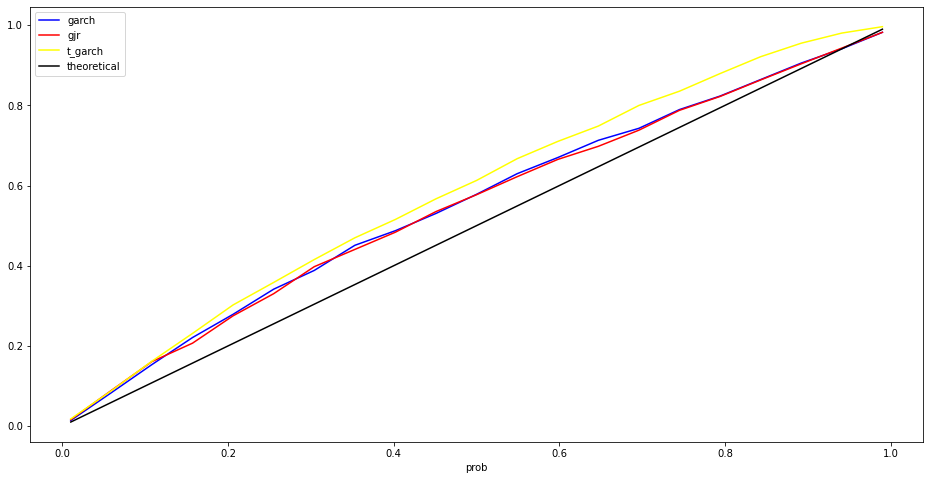

In [121]:
fig, ax = plt.subplots(figsize = (16,8))
coverage_df.plot(color = ['Blue','Red','Yellow','Black'], ax = ax)

In [122]:
coverage_df

,garch,gjr,t_garch,theoretical
prob,,,,
0.010,0.014032,0.015903,0.017774,0.010
0.059,0.083255,0.088868,0.087933,0.059
0.108,0.153414,0.160898,0.161833,0.108
0.157,0.220767,0.206735,0.231057,0.157
0.206,0.278765,0.275023,0.302152,0.206
0.255,0.341441,0.330215,0.358279,0.255
0.304,0.388213,0.397568,0.415341,0.304
0.353,0.450889,0.440599,0.469598,0.353
0.402,0.487371,0.483630,0.515435,0.402


# Interval score functions

In [111]:
def score(x,lower,upper,prob):
    return (upper-lower) + (2/(1-prob))*(max(x-upper,0) + max(lower-x,0))

In [113]:
score_df = pd.DataFrame(columns = ['prob','garch', 'gjr','t_garch']).set_index('prob')
prob_list = np.linspace(.05,.95,21)

for prob in prob_list:
    score_df.loc[prob] = 0.0

garch_mean = garch_fit.params[0]    
gjr_mean = gjr_fit.params[0]
t_garch_mean = t_garch_fit.params[0]    
t_garch_dist = t_garch_fit.params[4]

for time in ts.index:
    actual = ts.loc[time,'target']
    
    garch_vol =  ts.loc[time,'garch']
    gjr_vol = ts.loc[time,'gjr']
    t_garch_vol = ts.loc[time,'t_garch']

    for prob in prob_list:        
        garch_ci = scipy.stats.norm.interval(prob, loc= garch_mean, scale= garch_vol)
        gjr_ci = scipy.stats.norm.interval(prob, loc= gjr_mean, scale= gjr_vol)
        t_garch_ci = scipy.stats.t.interval(prob, t_garch_dist, loc=t_garch_mean, scale=t_garch_vol)
        
        score_df.loc[prob] = score_df.loc[prob] + [score(actual, garch_ci[0],garch_ci[1], prob),
                                                   score(actual, gjr_ci[0],gjr_ci[1], prob),
                                                   score(actual, t_garch_ci[0],t_garch_ci[1], prob) ]
                                                                
score_df = score_df.div(len(ts))

Text(0.5, 1.0, 'Interval forecast scores')

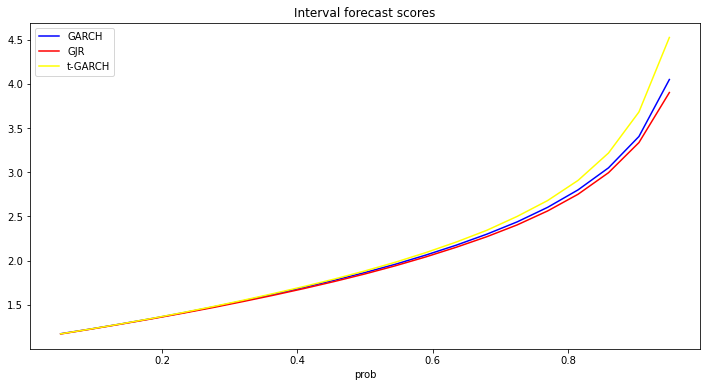

In [119]:
fig, ax = plt.subplots(figsize = (12,6))
score_df.plot(color = ['Blue','Red','Yellow'], ax = ax)

ax.legend(['GARCH', 'GJR','t-GARCH'])
ax.set_title('Interval forecast scores')

In [115]:
score_df

,garch,gjr,t_garch
prob,,,
0.050,1.171788,1.169083,1.170607
0.095,1.226226,1.224169,1.226049
0.140,1.283878,1.281753,1.284288
0.185,1.344120,1.340820,1.345493
0.230,1.407388,1.402873,1.410450
0.275,1.474591,1.467487,1.479007
0.320,1.544728,1.536715,1.551012
0.365,1.619093,1.608262,1.627265
0.410,1.696759,1.683658,1.706849
